# Experiment on the dataset Fashion MNIST
### with basic neural network, decision tree, CNN ...

Each training and test example is assigned to one of the following labels:

- 0 T-shirt/top
- 1 Trouser
- 2 Pullover
- 3 Dress
- 4 Coat
- 5 Sandal
- 6 Shirt
- 7 Sneaker
- 8 Bag
- 9 Ankle boot

## Imports

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

def print_accuracy(y_test, y_pred):
    print("Absolute error:", (y_test != y_pred).sum())
    print("Accuracy:", accuracy_score(y_test, y_pred))

    print("F1-scores (macro):", f1_score(y_test, y_pred, average='macro'))
    print("F1-scores (weighted):", f1_score(y_test, y_pred, average='weighted'))

    mat = confusion_matrix(y_test, y_pred)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    plt.tight_layout()  # Ensure everything fits well
    plt.show()


## Download the dataset

In [36]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("zalando-research/fashionmnist")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\cpick\.cache\kagglehub\datasets\zalando-research\fashionmnist\versions\4


### Load the csv

In [37]:
train_df = pd.read_csv(f"{path}/fashion-mnist_train.csv")
test_df = pd.read_csv(f"{path}/fashion-mnist_test.csv")
train_df

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,1,0,0,0,0,0,0,0,0,0,...,73,0,0,0,0,0,0,0,0,0
59997,8,0,0,0,0,0,0,0,0,0,...,160,162,163,135,94,0,0,0,0,0
59998,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


C:\Users\cpick\AppData\Local\Temp\ipykernel_15760\270097961.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[0]


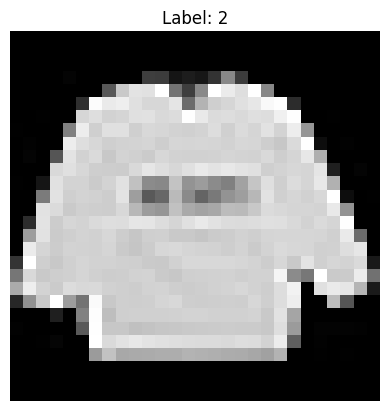

In [38]:
row = train_df.iloc[0]
label = row[0]
pixels = row[1:].values

# Reshape the pixels into a 28x28 image
image = pixels.reshape(28, 28)

# Display
plt.imshow(image, cmap='gray')
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

## Decision Tree

In [39]:
X_train = train_df.drop(columns=["label"])
y_train = train_df["label"]

X_test = test_df.drop(columns=["label"])
y_test = test_df["label"]

In [40]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)

Absolute error: 2020
Accuracy: 0.798
F1-scores (macro): 0.7981136474568917
F1-scores (weighted): 0.7981136474568918


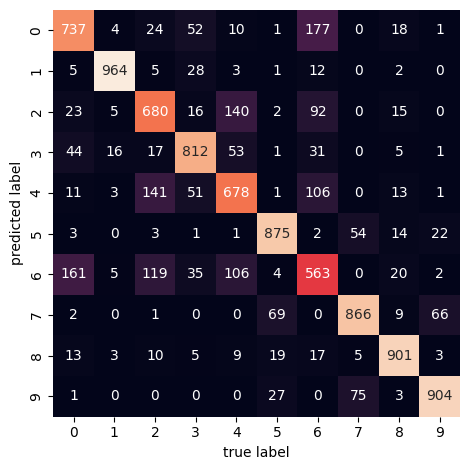

In [41]:
from sklearn.metrics import f1_score, accuracy_score
from sklearn.tree import plot_tree

y_pred = tree.predict(X_test)

print_accuracy(y_test, y_pred)

### 10 fold validation

In [42]:
from sklearn.model_selection import cross_val_score

model = DecisionTreeClassifier()
scores = cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy', n_jobs=8)

print("Scores for each fold:", scores)
print("Average accuracy:", scores.mean())

KeyboardInterrupt: 

Honestly, bad but for less than one minute on training on a laptop I think it's pretty ok. That will be a baseline anyway.

## Multi layer perceptron

In [ ]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', max_iter=300, random_state=0)

# Train it
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.8695


## Does data augmentation improve the performances ?


In [43]:
# let's start again

train_df = pd.read_csv(f"{path}/fashion-mnist_train.csv")
test_df = pd.read_csv(f"{path}/fashion-mnist_test.csv")

X_train = train_df.drop(columns=["label"])
y_train = train_df["label"]

X_test = test_df.drop(columns=["label"])
y_test = test_df["label"]



#### Apply data augmentation

In [54]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# 1. Define the augmentation pipeline
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),      # Random flip
    transforms.RandomRotation(10),           # Rotate images by +/- 10 degrees
    transforms.RandomAffine(0, translate=(0.1, 0.1)),  # Translate up to 10% height/width
    transforms.ToTensor(),                   # Convert PIL image to tensor
    transforms.Normalize((0.5,), (0.5,))      # Normalize pixel values to [-1, 1]
])

test_transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5,), (0.5,))
])

# 2. Load datasets with transform
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=train_transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=test_transform)

train_noaug_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=test_transform)
test_noaug_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

train_noaug_loader = DataLoader(train_noaug_dataset, batch_size=64, shuffle=True)
test_noaug_loader = DataLoader(test_noaug_dataset, batch_size=64, shuffle=False)

# 3. Now when you iterate over `train_loader`, images will be randomly augmented!


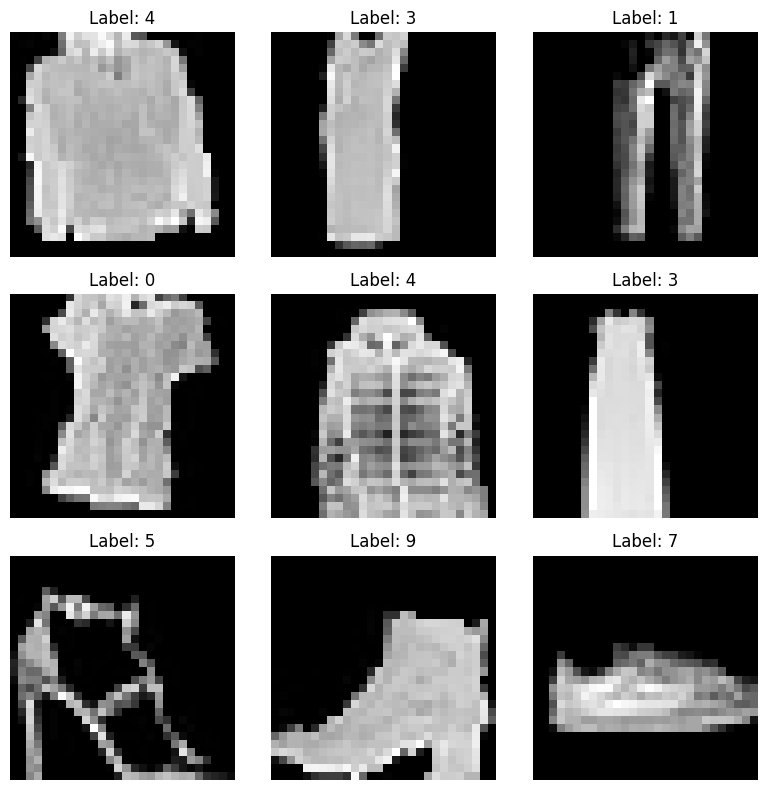

In [55]:
# Sample 9 random images
fig, axes = plt.subplots(3, 3, figsize=(8,8))

for i in range(9):
    idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[idx]
    
    img = img.squeeze(0)
    
    ax = axes[i // 3, i % 3]
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Label: {label}")
    ax.axis('off')

plt.tight_layout()
plt.show()

#### Convert for sklearn

In [46]:
from sklearn.tree import DecisionTreeClassifier

def convert_torch(dataset):
    X = []
    y = []

    for img, label in dataset:
        img = img.numpy().squeeze()  # Convert tensor to numpy, remove channel dimension
        X.append(img.flatten())      # Flatten from 28x28 -> 784
        y.append(label)

    X = np.array(X)
    y = np.array(y)
    return X, y

X_train, y_train = convert_torch(train_dataset)
X_test, y_test = convert_torch(test_dataset)

print(X_train.shape)  # (60000, 784)
print(y_train.shape)  # (60000,)



(60000, 784)
(60000,)


In [47]:
# Train decision tree
model = DecisionTreeClassifier().fit(X_train, y_train)
y_pred = model.predict(X_test)


Absolute error: 3072
Accuracy: 0.6928
F1-scores (macro): 0.6937555270787419
F1-scores (weighted): 0.6937555270787419


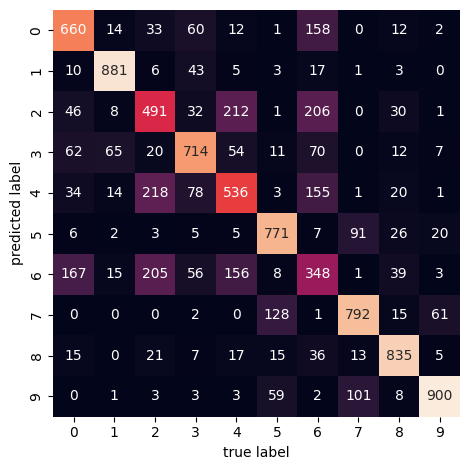

In [48]:
print_accuracy(y_test, y_pred)

Data augmentation seem to affect negatively the performance, it has difficulties predicting 2 and 4 (pullover and coat)

## CNN

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Step 1: Define your CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # (28,28) -> (28,28)
        self.pool = nn.MaxPool2d(2, 2)                           # (28,28) -> (14,14)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # (14,14) -> (14,14)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)                    # after second pooling (7x7)
        self.fc2 = nn.Linear(128, 10)                            # 10 classes
        
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train(new_train_loader):
    # Step 3: Initialize model, loss, optimizer

    model = SimpleCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Step 4: Train the model
    num_epochs = 5

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for images, labels in new_train_loader:
            images, labels = images.to(device), labels.to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)

            # Loss
            loss = criterion(outputs, labels)

            # Backward pass + Optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")
    return model


Finished Training ✅


In [57]:
model = train(train_loader)

Epoch [1/5], Loss: 0.6404
Epoch [2/5], Loss: 0.4402
Epoch [3/5], Loss: 0.3807
Epoch [4/5], Loss: 0.3485
Epoch [5/5], Loss: 0.3253


In [56]:
model_no_aug = train(train_noaug_loader)


Epoch [1/5], Loss: 0.4336
Epoch [2/5], Loss: 0.2763
Epoch [3/5], Loss: 0.2312
Epoch [4/5], Loss: 0.1974
Epoch [5/5], Loss: 0.1725


Augmentation:
Absolute error: 962
Accuracy: 0.9038
F1-scores (macro): 0.9029619783095459
F1-scores (weighted): 0.9046380216904542


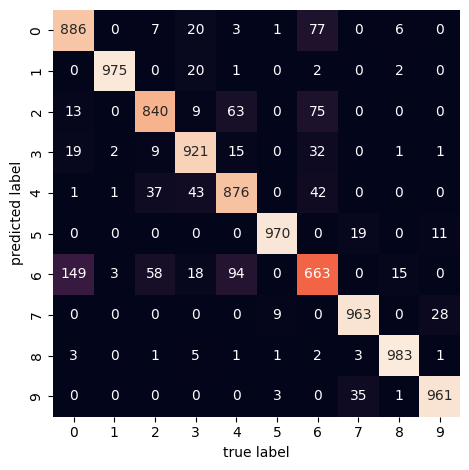

No augmentation:
Absolute error: 848
Accuracy: 0.9152
F1-scores (macro): 0.915150974225066
F1-scores (weighted): 0.9152490257749339


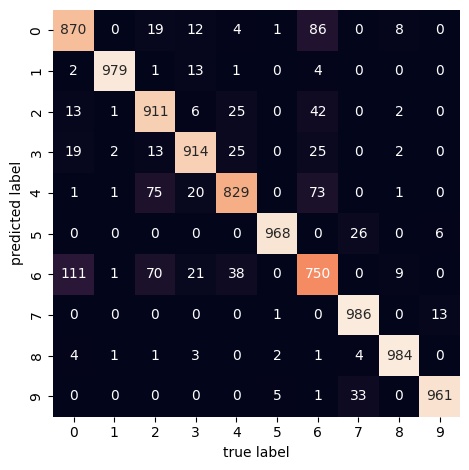

In [60]:
def get_all_predictions(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    all_predictions = []
    all_labels = []

    with torch.no_grad():  # Disable gradient calculation (inference only)
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Get model outputs
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)  # Get the index of the max output

            # Append predictions and labels
            all_predictions.extend(predicted.cpu().numpy())  # Move to CPU and convert to numpy
            all_labels.extend(labels.cpu().numpy())
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    return all_predictions, all_labels

y_pred, y_test = get_all_predictions(model, test_loader, device)
print("Augmentation:")
print_accuracy(y_pred, y_test)

y_pred, y_test = get_all_predictions(model_no_aug, test_noaug_loader, device)
print("No augmentation:")
print_accuracy(y_pred, y_test)
